# SIT744 Assignment 2: Deep Learning Project 

<div class="alert-info">
    <p>Due: <strong>8:00pm 5 June 2023</strong>  (Monday)</p>

This is an <strong>individual</strong> assignment. It contributes <strong>40%</strong> to your final mark. Read the assignment instruction carefully.

## **Task 1 (P Task) Smart Recycling using Deep Learning**

In Assignment 1, you tackled the image classification problem in Fashion-MNIST. There, you used a Densely Connected Neural Network. In Assignment 2, you will apply the best practices of deep-learning computer vision to make something useful for our planet—waste classification.


####**Task 1.1 Define a problem:**

######***Define an image classification problem that may help people better recycle, particularly by reducing contamination.***

Wish recycling is the act of recycling something that cannot be recycled. At best wish recycling is an inconvenience, at worst it can create more waste and/or compromise other recycling processes [1].

Wish recycling stems from an individuals intentions to recycle rather than contribute to landfill [1]. Ultimately the individual is trying to help the problem but is actually contributing to making it worse as the things that should be recycled become harder to distinguish or separate.

I propose an app that uses image classification to determine if an item of rubbish is recyclable in Victoria. For items that cannot be recycled the app will subsequently add the item and the users comments to a database Victorian Government to begin quantifying the items that the community things ‘should’ be recycled. This action of creating quantitative and qualitative data can help the Victorian Government set priorities to create solutions to be able to recycle these items in future. It also helps the user to ‘feel’ that they have contributed positively to the problem and may appease them enough to prevent further wish recycling.

######***Describe the desired inputs and outputs, including the target classes.***

Inputs: pictures of rubbish in reasonable condition
Outputs/target classes: 
*   Item label
*   Recyclable
*   Not recyclable

Target classes: 
*   Cardboard
*   Plastic
*   Paper
*   Metal
*   Glass
*   Rubbish/trash

Each of the above target classes would filter into another level of categorisation into:
* 	Recyclable
* 	Not recyclable



####**Task 1.2 Make a plan**

######***What dataset can you use to develop a deep learning solution?***

The Garbage Classification Dataset [2] is a good place to start for the image classification component of the problem.

A small reference table has been created based on the information extracted from the Recycling Victoria Kerbside Education and Behaviour Change Research report [3, pp. 29]. This reference table will identify where a common disposable item belongs in which target class.

######***How many images do you need? How many for training? How many for testing?***

The number of images in the Garbage Classification Dataset by classification are cardboard (393), glass (491), metal (400), paper(584), plastic (472) and trash(127) [2].

I will do a 90/10 split from training and testing.

######***Do you need to label the images yourself?***

The images are already labelled.

######***How do you determine if your model is good enough?***

I will be looking at Accuracy, Loss, Precision and Recall to determine how well the model is performing. 

I will look at a confusion matrix to assess the performance for each of the classes.

I will also look at the Accuracy and Loss training and validation curves plotted against the number of epochs which will allow me to see if the model is overfitting.

#####**Task 1.3 Implement a solution:**

Please see Code set below as a response to task 1.3.

In [1]:
#Importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import urllib
import itertools
import random, os, glob
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

from datetime import datetime
from packaging import version

import os

In [1]:
#mounting google drive to access data files/images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Create a TensorBoard callback
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

#####***Collect relevant data.***

In [4]:
#mapping the first directory path
dir_path = "/content/drive/MyDrive/archive-2/Garbage-classification/"

In [5]:
#setting target size and labels
target_size = (224, 224)
waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4, "trash":5}

In [6]:
#function to load the dataset
def load_ds(path, waste_labels_):
  x = []
  labels = []
  image_paths = sorted(list(paths.list_images(path)))
  for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    x.append(img)
    label = image_path.split(os.path.sep)[-2]
    labels.append(waste_labels_[label])
  x, labels = shuffle(x, labels, random_state=42)
  input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
  print("X shape: ", np.array(x).shape)
  print(f"Number of Labels: {len(np.unique(labels))} , Number of Observation: {len(labels)}")
  print("Input Shape: ", input_shape)
  return x, labels, input_shape

In [7]:
#loading the Garbage Classifciation dataset
x, labels, input_shape = load_ds(dir_path, waste_labels)

X shape:  (2527, 224, 224, 3)
Number of Labels: 6 , Number of Observation: 2527
Input Shape:  (224, 224, 3)


In [8]:
#function to visualise the data/images
def vis_img(image_batch, labels, num_of_img):
  plt.figure(figsize=(10,10))
  for n in range(num_of_img):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=len(np.unique(labels)))[n] == 1][0].title())
    plt.axis("off")

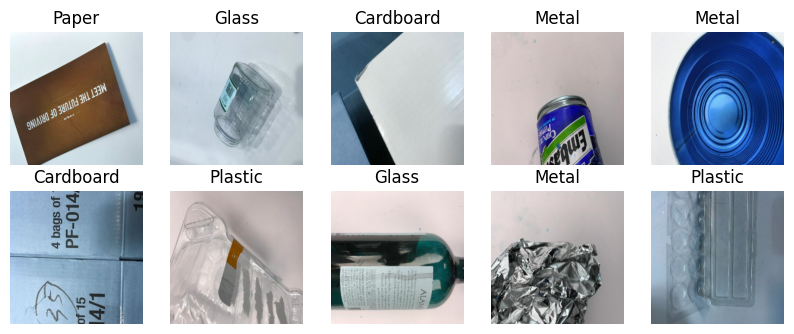

In [9]:
#visualising the data/images
vis_img(x, labels, 10)

In [10]:
#setting text labels - this is used later
labels2 = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

#####***Develop a learning model***

In [11]:
#pre-processing function
def data_prep(path_):
  #Data augmentation in preperation for section 2 - we will not use this in section 1
  train_aug = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1,
                             rescale=1./255,
                             shear_range=0.1,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
  #preparing trianing and validation data
  train = ImageDataGenerator(rescale=1/255, validation_split=0.1)
  valid = ImageDataGenerator(rescale=1/255, validation_split=0.1)
  
  train_aug_generator = train_aug.flow_from_directory(directory=path_,
                                              target_size=(target_size),
                                              class_mode="categorical",
                                              subset="training")
  
  train_generator = train.flow_from_directory(directory=path_,
                                              target_size=(target_size),
                                              class_mode="categorical",
                                              subset="training")
  
  valid_generator = valid.flow_from_directory(directory=path_,
                                            target_size=(target_size),
                                            batch_size=251,
                                            class_mode="categorical",
                                            subset="validation")
  return train_generator, valid_generator, train_aug_generator

In [12]:
#generating the data to feed our model(s)
#train_aug_generator is for use in seciton 2. It will not be used in section 1
train_generator, valid_generator, train_aug_generator = data_prep(dir_path + '/Images/')

Found 2276 images belonging to 6 classes.
Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [13]:
#function to create our model(s)
def create_fit_model(train_generator, valid_generator, summary=True, fit=True, epochs=30):
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
 
  model.add(Flatten())

  model.add(Dense(units=6, activation="softmax"))

  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

  callbacks = [EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"), 
              ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1),
              tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')]
  
  if summary:
    model.summary()
  
  if fit:
    history = model.fit_generator(generator=train_generator, epochs=epochs, validation_data=valid_generator, 
                                callbacks=callbacks, workers=4, steps_per_epoch=10, validation_steps=251//32) 
                                                                                                              

  return model, history

In [14]:
#fitting our model 
#ideally we would be running 70 or more epochs to start and see where the model diverges
#but I did not have the processing power to be able to accompolish this.
model, history = create_fit_model(train_generator, valid_generator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 100352)            0

In [15]:
#function to evaluate the model
def model_evaluate(model_, valid_data_, history_):
  loss, precision, recall, acc = model_.evaluate(valid_data_, batch_size=32)
  print("Test Accuracy: %.2f" % (100 * acc))
  print("Test Loss: %.2f" % (100 * loss))
  print("Test Precision: %.2f" % (100 * precision))
  print("Test Recall: %.2f" % (100 * recall))

  X_test, y_test = valid_data_.next()
  y_pred = model_.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(y_test, axis=1)
  target_names = list(waste_labels.keys())
  print(classification_report(y_test, y_pred, target_names=labels2))

  plt.figure(figsize=(20,5))
  plt.subplot(1,2,1)
  plt.plot(history_.history["acc"], color="r", label="Training Accuracy")
  plt.plot(history_.history["val_acc"], color="b", label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Accuracy", fontsize=16)
  plt.ylim([min(plt.ylim()),1])
  plt.title("Training and Validation Accuracy", fontsize=16)

  plt.subplot(1,2,2)
  plt.plot(history_.history["loss"], color="r", label="Training Loss")
  plt.plot(history_.history["val_loss"], color="b", label="Validation Loss")
  plt.legend(loc="upper right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Loss", fontsize=16)
  plt.ylim([0, max(plt.ylim())])
  plt.title("Training and Validation Loss", fontsize=16)

  return y_test, y_pred

1/1 [==============================] - 10s 10s/step - loss: 1.4568 - precision: 0.5822 - recall: 0.3386 - acc: 0.4701
Test Accuracy: 47.01
Test Loss: 145.68
Test Precision: 58.22
Test Recall: 33.86
8/8 [==============================] - 7s 817ms/step
              precision    recall  f1-score   support

   cardboard       0.78      0.35      0.48        40
       glass       0.46      0.32      0.38        50
       metal       0.38      0.63      0.47        41
       paper       0.53      0.73      0.61        59
     plastic       0.38      0.27      0.32        48
       trash       0.43      0.46      0.44        13

    accuracy                           0.47       251
   macro avg       0.49      0.46      0.45       251
weighted avg       0.50      0.47      0.46       251



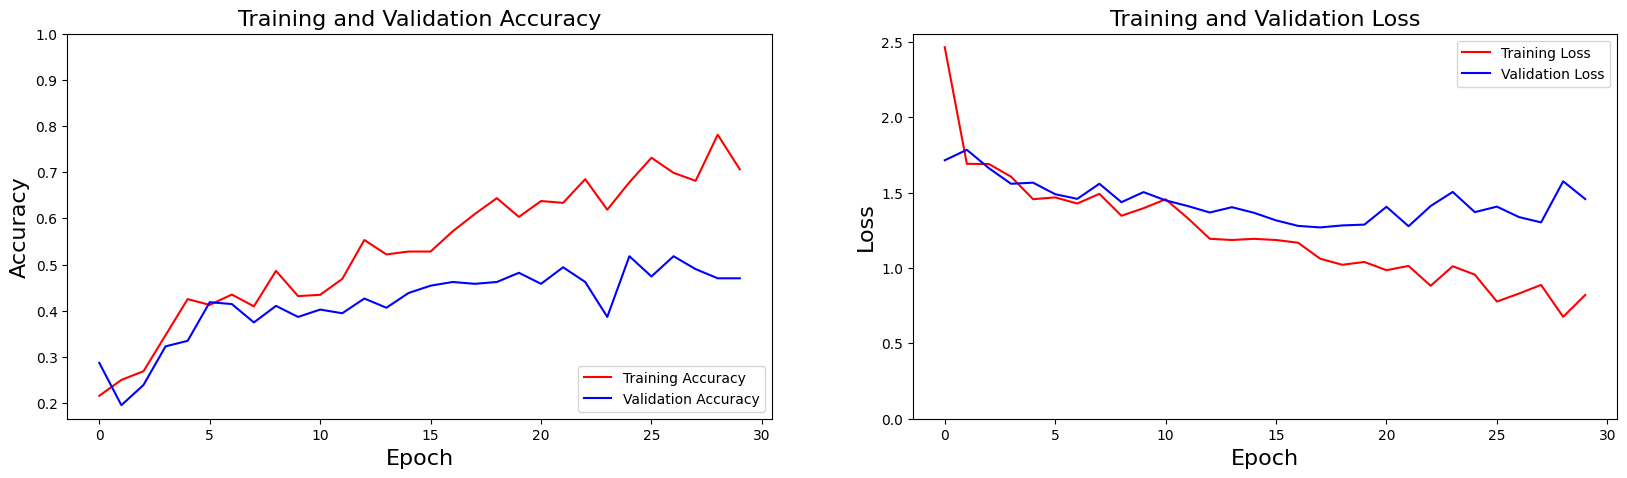

In [16]:
#evaluating the first model
y_test, y_pred = model_evaluate(model, valid_generator, history)

In [17]:
#function to plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
def plot_cm(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.OrRd):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  
  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = ".2f" if normalize else "d"
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True Labels", fontweight="bold")
  plt.xlabel("Predicted Labels", fontweight="bold")

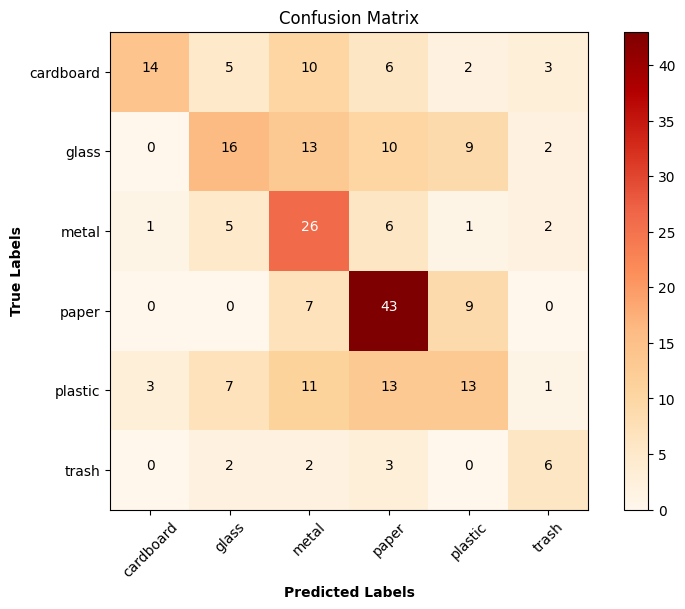

In [18]:
#plotting confusion matrix
plot_cm(cm, waste_labels.keys())

In [19]:
#function to test our model
def model_test(path, model_):
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0
  p = model_.predict(img.reshape(1,224,224,3))
  predicted_class = np.argmax(p[0])
  return img, p, predicted_class

In [20]:
#function to plot our test image
waste_labels = {0:"cardboard", 1:"glass", 2:"metal", 3:"paper", 4:"plastic", 5:"trash"}
def plot_model_test(img, p, predicted_class):
  plt.axis("off")
  plt.imshow(img.squeeze())
  plt.title("Maximum Probabilty: " + str(np.max(p[0], axis=-1)) + "\n" + "Predicted Class: " + str(waste_labels[predicted_class]))
  plt.imshow(img);

In [21]:
#running the test data/image
img, p, predicted_class = model_test('/content/drive/MyDrive/archive-2/Garbage-classification/Images/paper/paper101.jpg', model)

1/1 [==============================] - 0s 48ms/step


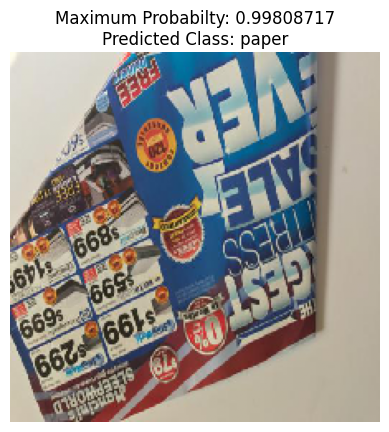

In [22]:
#plottin gthe test data/image
plot_model_test(img, p, predicted_class)

####***Report the model performacne against the success criteria that you define***

Although the accuracy, loss, precision and recall scores all appear to be heading in the right direction, when we look at the training and validation tables we can see that we have been overfitting from about the fifth epoch. This means that even though our accuracy score is sitting at 56%, replicating this with test data will not be possible or consistent.

Our confusion matrix is showing a positive outcome with good representation across the classes. But again this model has been over fitted, so these results are not valid.


#####**End of Section 1**

#####***References:***

[1]	T. Farnsworth. "What is Wish-Cycling and Why Does It Matter?" Recycle Nation. https://recyclenation.com/2020/12/what-is-wish-cycling-and-why-does-it-matter/ (accessed 4 May 2023.

[2]	B. L. Aadhav Vignesh, hamk. Garbage Classification Data. [Online]. Available: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification?select=one-indexed-files.txt

[3]	S. J. David Spicer, Steffi Chong, "Recycling Victoria Kerbside Education and Behaviour Change Research," Kantar, sustainability.vic.gov.au, 4 March 2021 2021. Accessed: 4 May 2023. [Online]. Available: https://assets.sustainability.vic.gov.au/susvic/Report-Waste-Recycling-Victoria-Kerbside-Education-and-Behaviour-Change-Research.pdf



## **Task 2 (C Task) Analyse and improve the model**

####**Task 2.1 Build an input pipeline for data augmentation**

######***Build a data preprocessing pipeline to perform data augmentation. (You may use Keras ImageDataGenerator or write your own transformations.)***

This was already done in section 1 (task 1.3) where we added the creation of the *'train_aug_generator'* dataset to our pre-processing for our CNN model. 


In [23]:
model2, history2 = create_fit_model(train_aug_generator, valid_generator)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 flatten_1 (Flatten)         (None, 100352)           

In [24]:
waste_labels2 = {0:"cardboard", 1:"glass", 2:"metal", 3:"paper", 4:"plastic", 5:"trash"}

1/1 [==============================] - 9s 9s/step - loss: 1.4581 - precision_1: 0.6585 - recall_1: 0.2151 - acc: 0.4024
Test Accuracy: 40.24
Test Loss: 145.81
Test Precision: 65.85
Test Recall: 21.51
8/8 [==============================] - 9s 1s/step
              precision    recall  f1-score   support

   cardboard       0.48      0.65      0.55        40
       glass       0.46      0.34      0.39        50
       metal       0.45      0.22      0.30        41
       paper       0.42      0.46      0.44        59
     plastic       0.29      0.44      0.35        48
       trash       0.25      0.08      0.12        13

    accuracy                           0.40       251
   macro avg       0.39      0.36      0.36       251
weighted avg       0.41      0.40      0.39       251



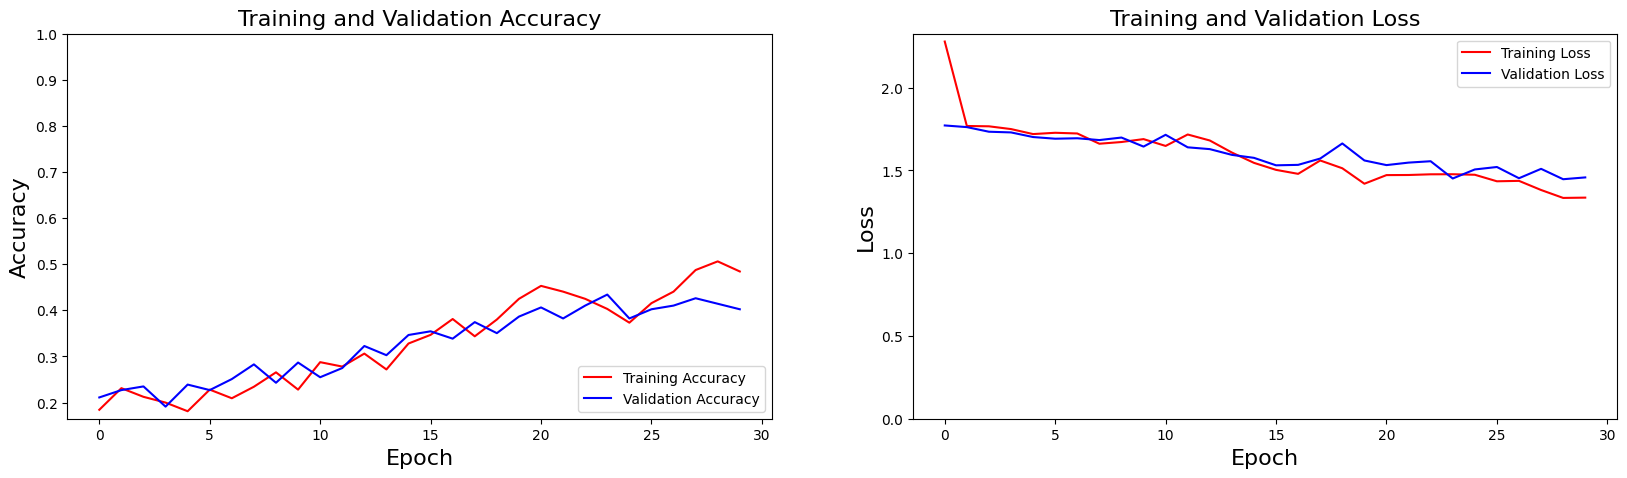

In [25]:
y_test2, y_pred2 = model_evaluate(model2, valid_generator, history2)

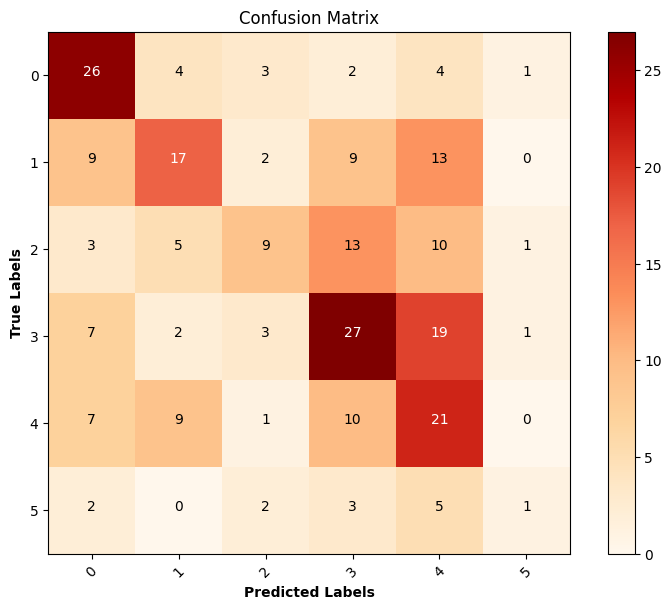

In [26]:
cm2 = confusion_matrix(y_test2, y_pred2)
plot_cm(cm2, waste_labels.keys())


######***Report the model performance with the pipeline added. How much performance gain have you achieved?***    

Referencing our evaluation metrics from model1 and model2 we can compare the results to measure our performance difference. Looking solely at the metrics it would appear that there has only been gain in loss measures, and there has actually been a decrease in performance in Accuracy, precision and recall.

The class measures also appear to show little gains with the exception of the 'trash' class.

However if we look at our validation and loss curves we can see that in model1 the curves begin to diverge at fice epochs. But in model 2 we are yet to see any diverange up to epoch 30. This indicates that our model still requires more trianing epochs to reach it's potential. In additon to this, is the gradient of the curves. In model1 the curve is near flat lines showing little to no improvement in accuracy and loss. However in model 2 the acuracy curve gradient is still showing a climb, and the loss curve gradient is showing a decline. This indicates again that the model is yet ot reach it's potential.

Although after 30 epochs there is no clear performance gain after augmenting the data, we can see that if we were able to increase the number of epochs, we would likely increase the performance for model2. This is not the case for model1, that has been overfitting since the fifth epoch.

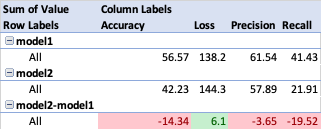

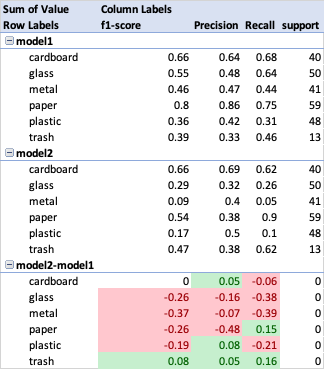

######***Profile your input pipeline to identify the most time-consuming operation. What actions have you taken to address that slow operation? (*Hint: You may use a profiler such as the [TensorFlow Profiler](https://github.com/tensorflow/profiler).*)***

I have been unable to access 'profiler' on the TensorBoard application. I have been unable to connect to and use GPU and the plugin does not work with CPU. 


In [27]:
#import tensorflow as tf
#print(tf.config.experimental.get_memory_info('GPU:0'))

In [28]:
#pip install -U tensorboard-plugin-profile

In [29]:
#%reload_ext tensorboard
#%tensorboard --logdir=logs

####**Task 2.2 Compare the performance under equal training time**

######***You may notice that with your pipeline, the model performance improves, but at the cost of a longer training time per epoch. Is the additional training time well spent? Compare the dynamic of model performance (e.g., classification accuracy on the test data) with and without data augmentation, when equal training time is spent in the two scenarios.***

As the models had similar training times I compared both models with a subset of images. 

The classifications in model 1 appear to be more correct than model 2. But again we need more epochs to be able to determine the efficacy of the models.

Where the images are incorrectly classified the probability scores are low, indicating that there would have been low probability scores for several classes and thus more epochs would help with improving the feature differentiation.


###**Model predictions - without data augmentation**

1/1 [==============================] - 0s 49ms/step


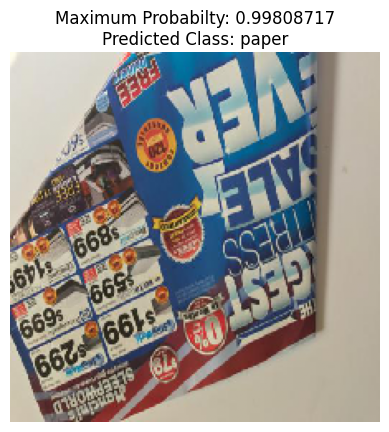

In [30]:
img3, p3, predicted_class = model_test('/content/drive/MyDrive/archive-2/Garbage-classification/Images/paper/paper101.jpg', model)
plot_model_test(img3, p3, predicted_class)

1/1 [==============================] - 0s 78ms/step


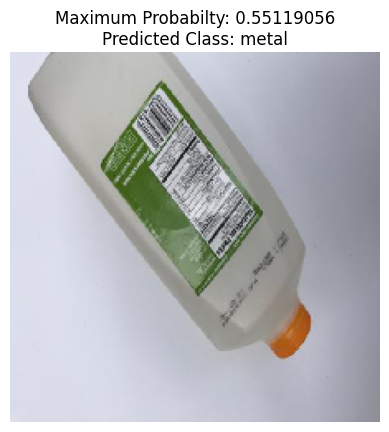

In [31]:
img4, p4, predicted_class = model_test('/content/drive/MyDrive/archive-2/Garbage-classification/Images/plastic/plastic101.jpg', model)
plot_model_test(img4, p4, predicted_class)


1/1 [==============================] - 0s 49ms/step


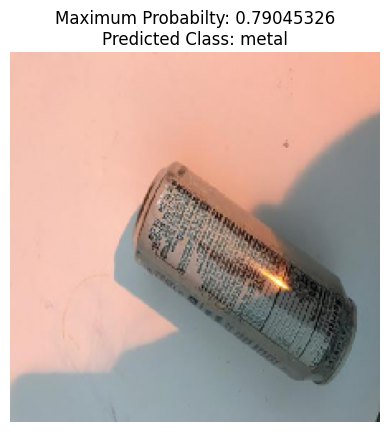

In [32]:
img5, p5, predicted_class = model_test('/content/drive/MyDrive/archive-2/Garbage-classification/Images/metal/metal101.jpg', model)
plot_model_test(img5, p5, predicted_class)


1/1 [==============================] - 0s 76ms/step


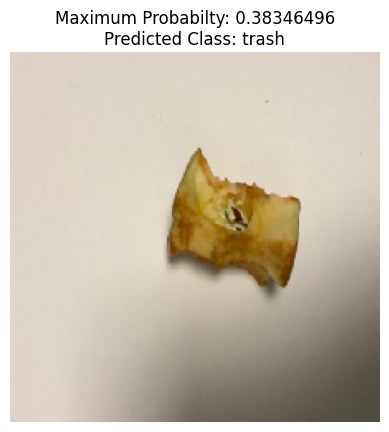

In [33]:
img6, p6, predicted_class = model_test('/content/drive/MyDrive/archive-2/Garbage-classification/Images/trash/trash101.jpg', model)
plot_model_test(img6, p6, predicted_class)

###**Model2 predictions - with data augmentation**

1/1 [==============================] - 0s 48ms/step


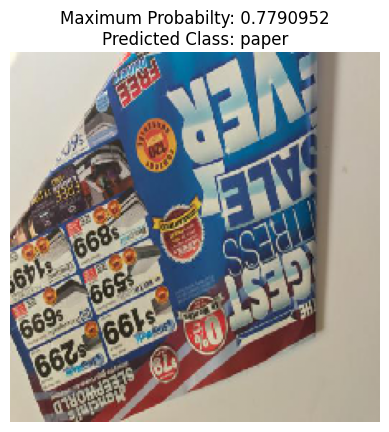

In [34]:
img7, p7, predicted_class = model_test('/content/drive/MyDrive/archive-2/Garbage-classification/Images/paper/paper101.jpg', model2)
plot_model_test(img7, p7, predicted_class)

1/1 [==============================] - 0s 52ms/step


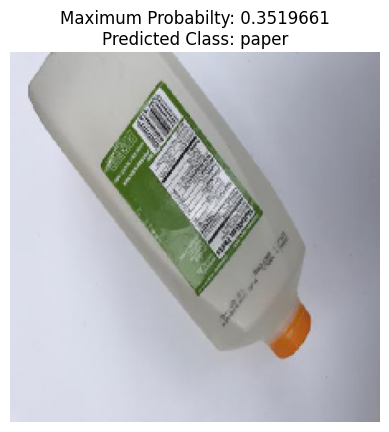

In [35]:
img8, p8, predicted_class = model_test('/content/drive/MyDrive/archive-2/Garbage-classification/Images/plastic/plastic101.jpg', model2)
plot_model_test(img8, p8, predicted_class)


1/1 [==============================] - 0s 56ms/step


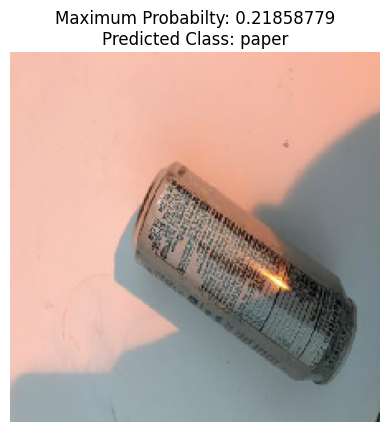

In [36]:
img9, p9, predicted_class = model_test('/content/drive/MyDrive/archive-2/Garbage-classification/Images/metal/metal101.jpg', model2)
plot_model_test(img9, p9, predicted_class)


####**Task 2.3 Identifying model strength and weakness**

######***Identify images that are incorrectly classified by your model. Do they share something in common? How do you plan to improve the model's performance on those images?***

***Plan to improve the models performance:***

Firstly I would run more epochs and look for where the model begins to diverge. Once I was able to find this point I would being to optimise the parameters. Assuming the augmented dataset provided a better result once we find the point of convergence I would look at reconfiguring the dropout in the model to see if this helped the accuracy, precision loss and recall scores. As well as the representation across features.

Once I was satisfied with those configurations I would then focus on improving generalisation. 

#####**End of Section 2**

## **Task 3 (D Task) Improve model generalisability across domains**

######***So far, you have used training and test images from the same source (via random data split). Now collect new test images from a different source. For example, you may take some photos yourself if you used downloaded images before.***
######***Otherwise, you may take new photos using a different mobile phone or against a different background.***

######***Show sample images from the original test data and the newly collected test data. In what ways are they different?***

The new images have a variety of backgrounds and are not captured with the intention of being used in. a classification dataset. They have more noise in the backgrounds and take up different proportions of the screen.

######***Feed the new test data into your model. Report the performance change.***

The test data did not perform very well in our model. Again it may be a symptom of the reduced epochs in training.

To resolve this issue there are some other processing steps that I can take:
*   Increase the number of epochs to just before the validation and training accuracy and loss values diverge, assuming these are on a trajectory of improvement 
*   In the data augmentation pipeline include the addition of ‘noise’ in the background of the garbage-classification dataset (all images taken on a white background) to better simulate real world pictures such as the new dataset.
*   Add more training data. Find more datasets and include more real world images that are not on a white background
*   Increase the regularisation by increasing the drop out rate


######***Improve your model so that it generalises better on unseen test images.***

I have added dropout a two dense layers to improve generalisation. The drop out will assist the model to focus on parapmeters that are having an impact ointhe model. The dense layers help drop out ensure it is making an informed choice of what to dropout.


In [37]:
#function to create our model(s) - improving for better generalisation
def create_fit_model2(train_generator, valid_generator, summary=True, fit=True, epochs=30):
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Flatten())

  model.add(Dense(units=64, activation="relu"))
  model.add(Dropout(rate=0.2))

  model.add(Dense(units=32, activation="relu"))
  model.add(Dropout(rate=0.2))

  model.add(Dense(units=6, activation="softmax"))

  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

  callbacks = [EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"), 
              ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1),
              tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')]
  
  if summary:
    model.summary()
  
  if fit:
    history = model.fit_generator(generator=train_generator, epochs=epochs, validation_data=valid_generator, 
                                callbacks=callbacks, workers=4, steps_per_epoch=10, validation_steps=251//32) 
                                                                                                              

  return model, history

In [38]:
model3, history3 = create_fit_model2(train_aug_generator, valid_generator)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 32)      

1/1 [==============================] - 0s 123ms/step


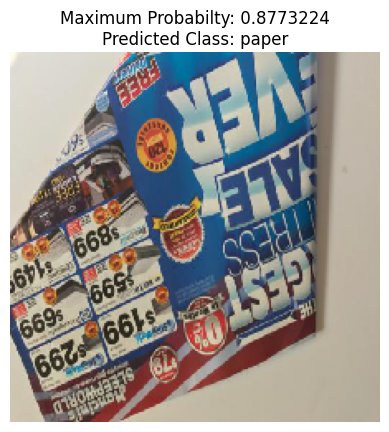

In [39]:
img2, p2, predicted_class = model_test('/content/drive/MyDrive/archive-2/Garbage-classification/Images/paper/paper101.jpg', model3)
plot_model_test(img2, p2, predicted_class)

1/1 [==============================] - 0s 50ms/step


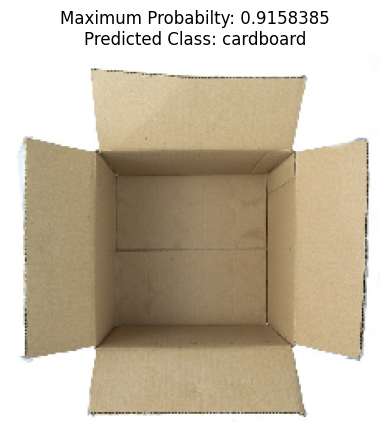

In [40]:
img_test, p_test, predicted_class = model_test('/content/drive/MyDrive/archive-2/test_images/Images/cardboard/cardboard001.jpeg', model3)
plot_model_test(img_test, p_test, predicted_class)

1/1 [==============================] - 12s 12s/step - loss: 1.3878 - precision_2: 0.7794 - recall_2: 0.2112 - acc: 0.4223
Test Accuracy: 42.23
Test Loss: 138.78
Test Precision: 77.94
Test Recall: 21.12
8/8 [==============================] - 6s 793ms/step
              precision    recall  f1-score   support

   cardboard       0.62      0.70      0.66        40
       glass       0.34      0.40      0.37        50
       metal       0.38      0.27      0.31        41
       paper       0.39      0.58      0.47        59
     plastic       0.41      0.27      0.33        48
       trash       0.00      0.00      0.00        13

    accuracy                           0.42       251
   macro avg       0.36      0.37      0.36       251
weighted avg       0.40      0.42      0.40       251



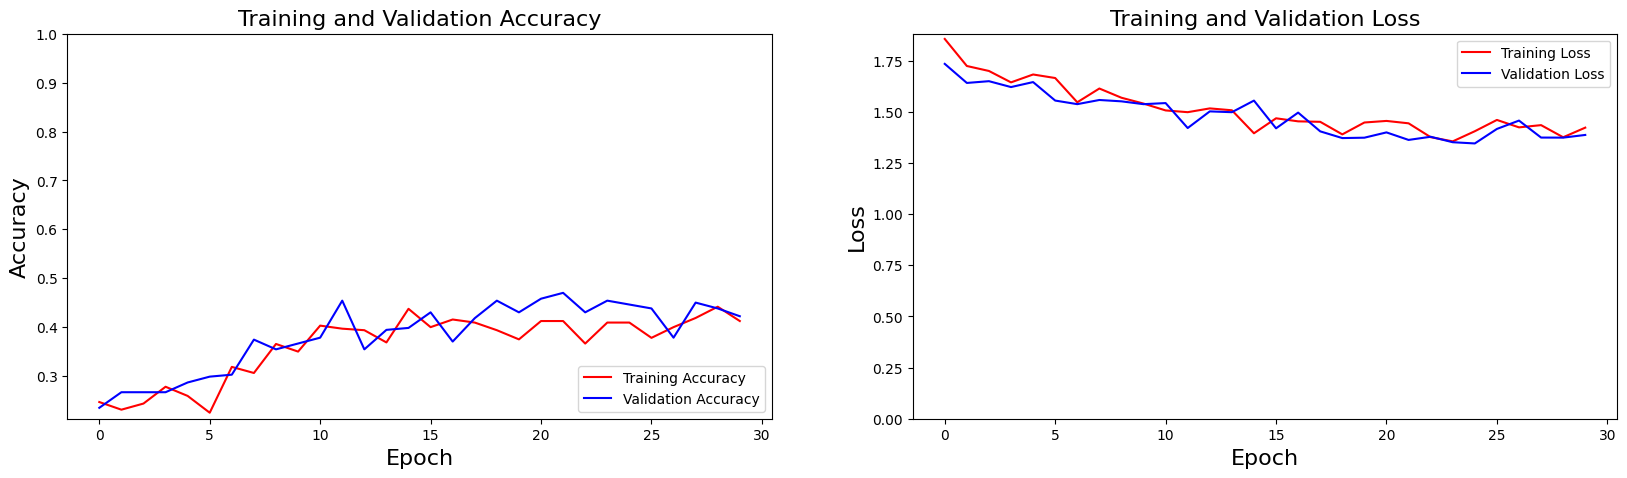

In [41]:
y_test3, y_pred3 = model_evaluate(model3, valid_generator, history3)

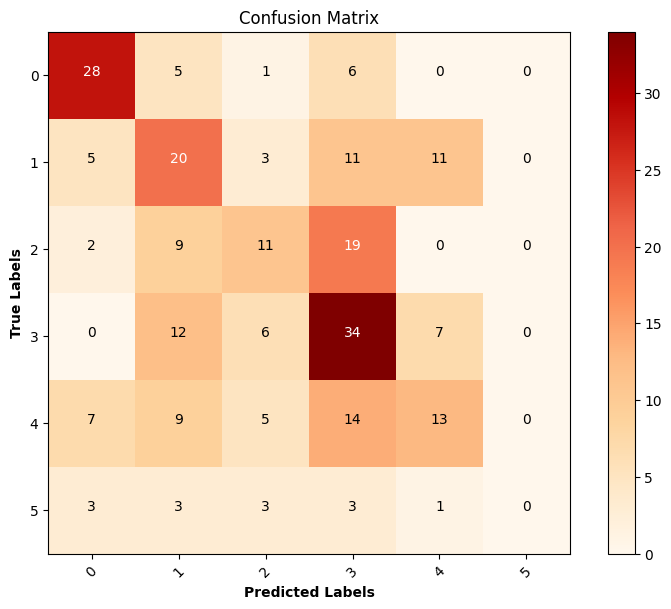

In [42]:
cm3 = confusion_matrix(y_test3, y_pred3)
plot_cm(cm3, waste_labels.keys())

#####**End of Section 3**

## **Task 4 (HD Task) Build a workable prototype**

######***Build a web/mobile app that people from your city council can use to determine what to recycle. Test your prototype with the target users and report their feedback.***

######***Upload your code into a GitHub repository.***


In [43]:
!pip install gradio
import gradio as gr


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [44]:
#function to test our model
def model_test_app(path):

  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0
  p = model2.predict(img.reshape(1,224,224,3))
  predicted_class = np.argmax(p[0])
  w_label = str(waste_labels[predicted_class])
  return w_label

In [45]:
model_test_app('/content/drive/MyDrive/archive-2/test_images/Images/cardboard/cardboard001.jpeg')

1/1 [==============================] - 0s 54ms/step


'paper'

In [46]:

app =  gr.Interface(fn = model_test_app, inputs=gr.Image(type="filepath", label="Let's picture your waste!"), outputs=gr.Textbox())
app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://f0849efd287aba076c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


######***Test your prototype with the target users and report their feedback.***
Two people tried my web app and they said it was cool when it worked. No utility yet in this version of the app. It needs to be evolved to determine what can be recycled and where.

######***Create a short video presentation about your product.***

https://video.deakin.edu.au/media/t/1_5ul0un2b


#####**End of Section 4**